In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

import settings as s
import Hearis as h
from Custom import Mouse

import scipy.io as sio

from scipy.stats import ranksums
    
batch = s.Batch()

#water_path = '/home/anverdie/Documents/Code/MFB_Paper/Water'
#mfb_path = '/home/anverdie/Documents/Code/MFB_Paper/MFB'

water_path = '/home/pouple/PhD/Code/MFB_Paper/Water'
mfb_path = '/home/pouple/PhD/Code/MFB_Paper/MFB'

plt.style.use('default')

In [2]:
class MouseMFB(object):
    def __init__(self, path, verbose=True, rmgaps=False):
        self.verbose = verbose
        self.path = path
        data = self.__load_data(self.path)
        self.day = data['Day'][0]
        self.corr = data['Correct'][0]
        self.idsound = data['SoundId'][0]
        self.idtrial = data['TrialId'][0]
        self.rule = data['Rule'][0]
        self.WeekDay = data['DayOfWeek'][0]
        self.ForkAct = data['ForkAct'][0]
        
        self.compute_fork()
        if rmgaps == 'Antonin':
            self.rmgaps_antonin()
        elif rmgaps == 'Brice':
            self.rmgaps_brice()
        
        self.split_in_sessions()
        
        if self.verbose: print('Mouse', os.path.basename(self.path)[1:-4], 'Loaded')
    
    def __load_data(self, path):
        return sio.loadmat(path)
    
    def compute_fork(self):
        # Need to do sanity check 
        ta_type = np.where(self.idtrial == 0 | 2, 0, self.idtrial) 
        self.fork = np.multiply(np.logical_not(np.logical_xor(ta_type, self.corr)), 1)

    def rmgaps_antonin(self):
        str_fork = [str(f) for f in self.fork]
        str_fork = ''.join(str_fork)
        no_licks = [[m.start(), m.end() - 1] for m in re.finditer('[0]+', str_fork) if m.end() - m.start() > 15]        
        print(no_licks)
        for gap in reversed(no_licks):
            self.corr = np.delete(self.corr, np.arange(gap[0], gap[1]))
            self.idtrial = np.delete(self.idtrial, np.arange(gap[0], gap[1]))
            self.idsound = np.delete(self.idsound, np.arange(gap[0], gap[1]))
            self.WeekDay = np.delete(self.WeekDay, np.arange(gap[0], gap[1]))
            self.day = np.delete(self.day, np.arange(gap[0], gap[1]))

    def rmgaps_brice(self):
        
        go_idx = [i for i, g in enumerate(self.idtrial) if g == 1]
        go_corr = [int(self.corr[i]) for i in go_idx]
        
        str_gos = [str(i) for i in go_corr]
        str_gos = ''.join(str_gos)
        no_licks = [[m.start(), m.end() - 1] for m in re.finditer('[0]+', str_gos) if m.end() - m.start() > 5]        
        print(no_licks)
        for gap in reversed(no_licks):
            self.corr = np.delete(self.corr, np.arange(gap[0], gap[1]))
            self.idtrial = np.delete(self.idtrial, np.arange(gap[0], gap[1]))
            self.idsound = np.delete(self.idsound, np.arange(gap[0], gap[1]))
            self.WeekDay = np.delete(self.WeekDay, np.arange(gap[0], gap[1]))
            self.day = np.delete(self.day, np.arange(gap[0], gap[1]))
    
    def split_in_sessions(self):
        self.corrs = []
        self.idsounds = []
        self.idtrials = []
        self.forks = []
        for day in np.unique(self.day):
            indices = np.where(self.day == day)
            self.corrs.append(self.corr[indices])
            self.idsounds.append(self.idsound[indices])
            self.idtrials.append(self.idtrial[indices])
            self.forks.append(self.fork[indices])
    
    def get_session_score(self):
        scores = [np.sum(corr)*100/len(corr) for corr in self.corrs]
        return scores
    
    def get_best_sessions_scores(self, n_sess):
        best_sess = np.argsort(self.get_session_score())[-n_sess:]
        return best_sess
    def keep_best_sessions(self, n_sess):
        best_sess = self.get_best_sessions_scores(n_sess)
        self.best_corrs = list(np.array(self.corrs, dtype=object)[best_sess])
        self.best_idsounds = list(np.array(self.idsounds, dtype=object)[best_sess])
        self.best_idtrials = list(np.array(self.idtrials, dtype=object)[best_sess])
        self.best_forks = list(np.array(self.forks, dtype=object)[best_sess])

In [3]:
# Paths for MFB data
# Paths for Water Data
def load_water(batch3=False, tag='PC', rmgaps=False, blank=False, verbose=True, rmblocks=None, linkday=None):
    mice_id = batch.id_first_batch
    if batch3: mice_id = batch.id_third_batch
    mice_water = [Mouse(path=os.path.join(water_path, f), tag=[tag], blank=blank, linkday=linkday, collab=False, rmgaps=rmgaps, verbose=verbose, rmblocks=rmblocks) for f in mice_id]
    
    return mice_water 

def load_MFB(tag='PC', verbose=False, rmgaps=False):
    # Load MFB mice data
    if tag =='PC': path = os.path.join(mfb_path, 'Psychophysics_MFB')
    elif tag =='DIS': path = os.path.join(mfb_path, 'GoVsNoGo_MFB')
    elif tag =='DISC': path = os.path.join(mfb_path, 'GoVsNoGo_ChirpStepLev1_MFB')
    elif tag =='DISC2': path = os.path.join(mfb_path, 'GoVsNoGo_ChirpStepLev2_MFB')

    mice_mfb = os.listdir(path)
    paths = [os.path.join(path, f) for f in os.listdir(path)]
    mice_mfb = [MouseMFB(path, verbose, rmgaps) for path in paths]
    
    return mice_mfb

In [5]:
mice_water_dis = load_water(batch3=False, verbose=True, tag='DIS',rmgaps='Antonin', linkday=True)
mice_mfb_dis = load_MFB(tag='DIS', verbose=False, rmgaps='Antonin')

Processing files for mice 660459...
DIS_26012021_660459_1.DAT
DIS_25012021_660459_1.DAT
Processing files for mice 660461...
DIS_26012021_660461_1.DAT
DIS_27012021_660461_1.DAT
DIS_25012021_660461_1.DAT
DIS_29012021_660461_1.DAT
DIS_28012021_660461_1.DAT
Processing files for mice 660462...
DIS_27012021_660462_1.DAT
DIS_28012021_660462_1.DAT
DIS_29012021_660462_1.DAT
DIS_25012021_660462_1.DAT
DIS_26012021_660462_1.DAT
Processing files for mice 660463...
DIS_26012021_660463_1.DAT
DIS_27012021_660463_1.DAT
DIS_25012021_660463_1.DAT
Processing files for mice 660267...
DIS_25012021_660267_1.DAT
DIS_26012021_660267_1.DAT
Processing files for mice 660268...
DIS_25012021_660268_1.DAT
DIS_26012021_660268_1.DAT
Processing files for mice 660269...
DIS_25012021_660269_1.DAT
DIS_29012021_660269_1.DAT
DIS_26012021_660269_1.DAT
DIS_28012021_660269_1.DAT
DIS_27012021_660269_1.DAT
[[811, 830], [2390, 2406]]
[[376, 394]]
[]
[[731, 746], [826, 848], [950, 967], [984, 1000], [1093, 1114], [2237, 2260], [23

In [6]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps='Antonin', linkday=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False, rmgaps='Antonin')

[[7381, 7396]]
[[797, 814]]
[[1376, 1396], [1453, 1481], [1797, 1817], [1876, 1897], [1911, 1936], [2130, 2156], [2578, 2597], [5778, 5816]]
[[4487, 4505], [4583, 4601], [4630, 4659], [4785, 4804], [5133, 5151], [5252, 5288], [5290, 5321], [5323, 5341]]
[[164, 192], [232, 265], [588, 603], [1874, 1895]]
[[871, 888], [893, 911], [931, 949], [8563, 8578]]
[[1146, 1175]]
[[343, 370], [395, 416], [418, 435], [692, 707], [716, 735], [741, 758], [1451, 1491], [1581, 1597], [1614, 1635], [1655, 1690], [1718, 1758], [1780, 1810], [1844, 1861], [2037, 2086], [2105, 2130], [2132, 2205], [2944, 2998], [3011, 3078], [3181, 3196], [5577, 5593], [5612, 5631], [5638, 5700], [6316, 6331]]


In [12]:
mice_water_disc = load_water(batch3=True, verbose=True, tag='DISC', rmgaps='Antonin', linkday=True)
mice_mfb_disc = load_MFB(tag='DISC', verbose=False, rmgaps='Antonin')

Processing files for mice 741150...
DISC_13012022_741150_1.DAT
DISC_07012022_741150_1.DAT
DISC_04012022_741150_1.DAT
DISC_22122021_741150_1.DAT
DISC_15122021_741150_2.DAT
DISC_14122021_741150_2.DAT
DISC_17122021_741150_2.DAT
DISC_13122021_741150_1.DAT
DISC_14012022_741150_1.DAT
DISC_05012022_741150_1.DAT
DISC_24122021_741150_2.DAT
DISC_16122021_741150_1.DAT
DISC_09122021_741150_2.DAT
DISC_03012022_741150_1.DAT
DISC_12012022_741150_1.DAT
DISC_14122021_741150_1.DAT
DISC_23122021_741150_1.DAT
DISC_09122021_741150_1.DAT
DISC_17122021_741150_1.DAT
DISC_14012022_741150_2.DAT
DISC_20122021_741150_3.DAT
DISC_14122021_741150_3.DAT
DISC_06012022_741150_1.DAT
DISC_23122021_741150_2.DAT
DISC_16122021_741150_2.DAT
DISC_21122021_741150_1.DAT
DISC_11012022_741150_1.DAT
DISC_10012022_741150_1.DAT
DISC_24122021_741150_1.DAT
DISC_10122021_741150_1.DAT
Processing files for mice 741151...
DISC_30122021_741151_1.DAT
DISC_10012022_741151_1.DAT
DISC_26122021_741151_1.DAT
DISC_29122021_741151_2.DAT
DISC_28122

# Learning Figure
- Boxplot 1er jour / 1er ensemble de trials supérieur à 80%
    - Ranksum
    - DIS, PC et DISC
    - Display points

0.6854434826775221
0.024027671425442047
[12, 3, 1, 26, 3]
[array([4, 5, 6, 7, 8, 9]), array([5]), array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), array([1, 4, 5, 6, 7, 8, 9])]


/home/anverdie/.conda/envs/kaggle/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

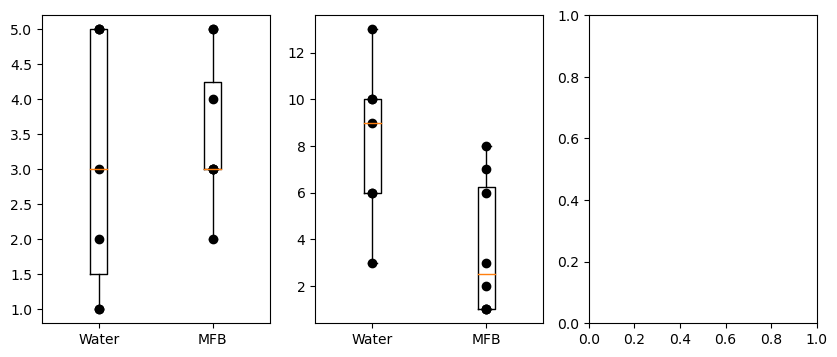

In [17]:
# Need to add ranksum still
# Maybe add jitter on points
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

####################################### DIS ###########################################
scores_water = [mouse.perf()[0] for mouse in mice_water_dis]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_dis]


# Water
first_day_over80_water = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_water]
# MFB
first_day_over80_mfb = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_mfb]


stdis, pdis = ranksums(first_day_over80_water, first_day_over80_mfb)
print(pdis)
axs[0].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Water', 'MFB'])
axs[0].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[0].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

####################################### PC ###########################################
scores_water = [mouse.perf()[0] for mouse in mice_water_pc]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_pc]

# Water
first_day_over80_water = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_water]

# MFB
first_day_over80_mfb = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_mfb]
stpc, ppc = ranksums(first_day_over80_water, first_day_over80_mfb)
print(ppc)
axs[1].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Water', 'MFB'])
axs[1].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[1].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

####################################### DISC ###########################################
scores_water = [mouse.perf(blank=True)[0] for mouse in mice_water_disc]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_disc]


# Water
first_day_over80_water = [np.where(np.array(s) >= 70)[0] + 1 for s in scores_water]
first_day_over80_water = [i[0] for i in first_day_over80_water if len(i) > 0]
print(first_day_over80_water)
# MFB####################################

first_day_over80_mfb = [np.where(np.array(s) >= 70)[0] + 1 for s in scores_mfb]
print(first_day_over80_mfb)
stdisc, pdisc = ranksums(first_day_over80_water, first_day_over80_mfb)

print(pdisc)
axs[2].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[2].set_xticks([1, 2])
axs[2].set_xticklabels(['Water', 'MFB'])
axs[2].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[2].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

plt.show()

# Learning curves
Courbe apprentissage pour DIS, PC et DISC. Moyenne avec dernière valeure

/home/anverdie/.conda/envs/kaggle/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


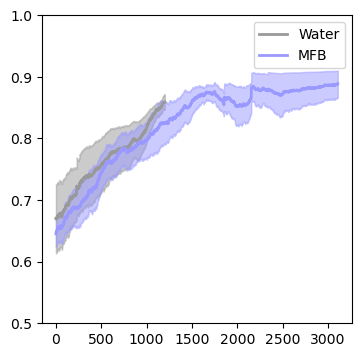

/home/anverdie/.conda/envs/kaggle/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


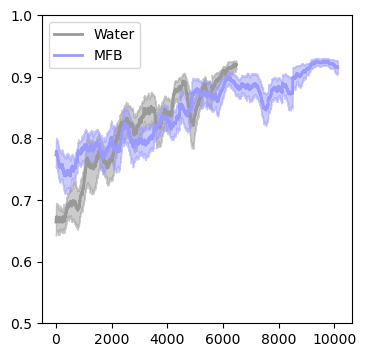

/home/anverdie/.conda/envs/kaggle/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


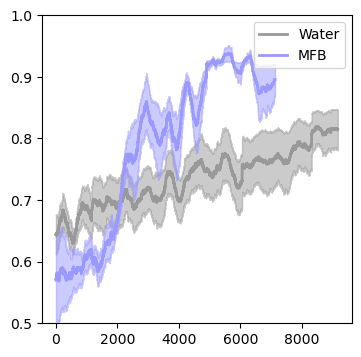

In [14]:
plt.style.use('default')

smoothness = 300
####################################### DIS ###########################################
fig, axs = plt.subplots(1, figsize=(4, 4))

all_convo_water = []
for mouse in mice_water_dis:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    #axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='maximum') for c in all_convo_water])
axs.plot(np.mean(all_convo_water, axis=0), c=(0.6, 0.6, 0.6, 1), linewidth=2, label='Water')
sem = np.std(all_convo_water, axis=0) / np.sqrt(all_convo_water.shape[0])
m = np.mean(all_convo_water, axis=0)
axs.fill_between(np.arange(len(m)), m - sem, m + sem, color=(0.6, 0.6, 0.6, 0.5))

all_convo_mfb = []
for mouse in mice_mfb_dis:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    #axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='maximum') for c in all_convo_mfb])
np.save('Paper/dis_learning', (all_convo_water, all_convo_mfb))
axs.plot(np.mean(all_convo_mfb, axis=0), c=(0.6, 0.6, 1, 1), linewidth=2, label='MFB')
sem = np.std(all_convo_mfb, axis=0) / np.sqrt(all_convo_mfb.shape[0])
m = np.mean(all_convo_mfb, axis=0)
axs.fill_between(np.arange(len(m)), m - sem, m + sem, color=(0.6, 0.6, 1, 0.5))
axs.set_ylim((0.5, 1))

plt.legend()
plt.savefig('Paper/DIS_learning.svg')
plt.show()

####################################### PC ###########################################
fig, axs = plt.subplots(1, figsize=(4, 4))

all_convo_water = []
for mouse in mice_water_pc:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    #axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='maximum') for c in all_convo_water])
axs.plot(np.mean(all_convo_water, axis=0), c=(0.6, 0.6, 0.6, 1), linewidth=2, label='Water')
sem = np.std(all_convo_water, axis=0) / np.sqrt(all_convo_water.shape[0])
m = np.mean(all_convo_water, axis=0)
axs.fill_between(np.arange(len(m)), m - sem, m + sem, color=(0.6, 0.6, 0.6, 0.5))

all_convo_mfb = []
for mouse in mice_mfb_pc:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    #axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='maximum') for c in all_convo_mfb])
np.save('Paper/pc_learning', (all_convo_water, all_convo_mfb))
axs.plot(np.mean(all_convo_mfb, axis=0), c=(0.6, 0.6, 1, 1), linewidth=2, label='MFB')
sem = np.std(all_convo_mfb, axis=0) / np.sqrt(all_convo_mfb.shape[0])
m = np.mean(all_convo_mfb, axis=0)
axs.fill_between(np.arange(len(m)), m - sem, m + sem, color=(0.6, 0.6, 1, 0.5))
axs.set_ylim((0.5, 1))
plt.legend()
plt.savefig('Paper/PC_learning.svg')
plt.show()

####################################### DISC ###########################################
fig, axs = plt.subplots(1, figsize=(4, 4))
all_convo_water = []
for mouse in mice_water_disc:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    #axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='maximum') for c in all_convo_water])
axs.plot(np.mean(all_convo_water, axis=0), c=(0.6, 0.6, 0.6, 1), linewidth=2, label='Water')
sem = np.std(all_convo_water, axis=0) / np.sqrt(all_convo_water.shape[0])
m = np.mean(all_convo_water, axis=0)
axs.fill_between(np.arange(len(m)), m - sem, m + sem, color=(0.6, 0.6, 0.6, 0.5))

all_convo_mfb = []
for mouse in mice_mfb_disc:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    #axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='maximum') for c in all_convo_mfb])
np.save('Paper/disc_learning', (all_convo_water, all_convo_mfb))
axs.plot(np.mean(all_convo_mfb, axis=0), c=(0.6, 0.6, 1, 1), linewidth=2, label='MFB')
sem = np.std(all_convo_mfb, axis=0) / np.sqrt(all_convo_mfb.shape[0])
m = np.mean(all_convo_mfb, axis=0)
axs.fill_between(np.arange(len(m)), m - sem, m + sem, color=(0.6, 0.6, 1, 0.5))
axs.set_ylim((0.5, 1))
plt.legend()
plt.savefig('Paper/DISC_learning.svg')
plt.show()

# Learning
- Psycoacoustic with error bars


In [39]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps='Antonin', linkday=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False, rmgaps='Antonin')
for mouse in mice_water_pc: mouse.select_best_trials(3)
for mouse in mice_mfb_pc: mouse.keep_best_sessions(3)

[[7381, 7396]]
[[797, 814]]
[[1376, 1396], [1453, 1481], [1797, 1817], [1876, 1897], [1911, 1936], [2130, 2156], [2578, 2597], [5778, 5816]]
[[4487, 4505], [4583, 4601], [4630, 4659], [4785, 4804], [5133, 5151], [5252, 5288], [5290, 5321], [5323, 5341]]
[[164, 192], [232, 265], [588, 603], [1874, 1895]]
[[871, 888], [893, 911], [931, 949], [8563, 8578]]
[[1146, 1175]]
[[343, 370], [395, 416], [418, 435], [692, 707], [716, 735], [741, 758], [1451, 1491], [1581, 1597], [1614, 1635], [1655, 1690], [1718, 1758], [1780, 1810], [1844, 1861], [2037, 2086], [2105, 2130], [2132, 2205], [2944, 2998], [3011, 3078], [3181, 3196], [5577, 5593], [5612, 5631], [5638, 5700], [6316, 6331]]
Best scores are : [90.     90.3125 90.625 ]
Best scores are : [84.375  85.625  89.0625]
Best scores are : [91.875 92.5   94.375]
Best scores are : [90.3125 91.5625 92.5   ]
Best scores are : [87.1875 89.375  89.375 ]
Best scores are : [86.875 87.5   91.25 ]
Best scores are : [84.6875 85.9375 91.25  ]


/home/anverdie/.conda/envs/kaggle/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


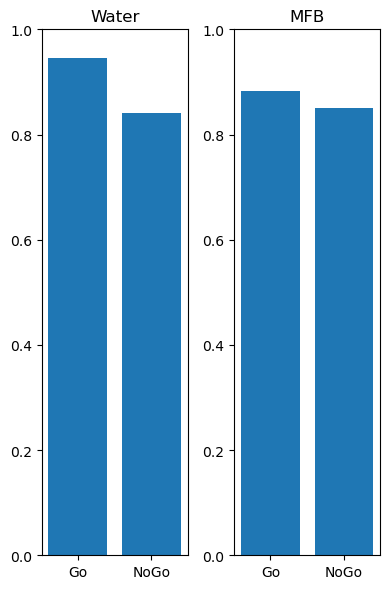

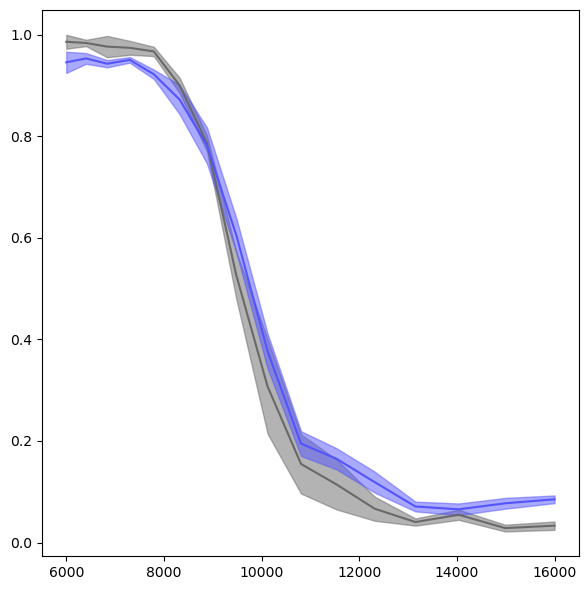

In [40]:
all_gos_water = []
all_nogos_water = []
for mouse in mice_water_pc:
    tr_corr = np.array([f.tr_corr for f in mouse.elphy]).flatten()
    ta_type = np.array([f.ta_type for f in mouse.elphy]).flatten()
    
    gos = [c for c, t in zip(tr_corr, ta_type) if t == 1]
    nogos = [c for c, t in zip(tr_corr, ta_type) if t == 2]
    
    all_gos_water.append(gos)
    all_nogos_water.append(nogos)
indiv_gos_water = np.array(all_gos_water)
indiv_nogos_water = np.array(all_nogos_water)

all_gos_water, all_nogos_water = np.array(all_gos_water).flatten(), np.array(all_nogos_water).flatten()
all_gos_water = np.sum(all_gos_water)/len(all_gos_water)
all_nogos_water = np.sum(all_nogos_water)/len(all_nogos_water)

all_gos_mfb = []
all_nogos_mfb = []

for mouse in mice_mfb_pc:
    corrs = np.concatenate(mouse.best_corrs)
    idtrials = np.concatenate(mouse.best_idtrials)
    gos = [c for c, t in zip(corrs, idtrials) if t == 1]
    nogos = [c for c, t in zip(corrs, idtrials) if t == 2]
    all_gos_mfb.append(gos)
    all_nogos_mfb.append(nogos)
indiv_gos_mfb = all_gos_mfb
indiv_nogos_mfb = all_nogos_mfb

np.save('Paper/Nogoindiv', (indiv_gos_water, indiv_nogos_water, indiv_gos_mfb, indiv_nogos_mfb))

all_gos_mfb = np.concatenate(all_gos_mfb)
all_nogos_mfb = np.concatenate(all_nogos_mfb)
all_gos_mfb = np.sum(all_gos_mfb)/len(all_gos_mfb)
all_nogos_mfb = np.sum(all_nogos_mfb)/len(all_nogos_mfb)

np.save('Paper/GoNoGo', (all_gos_water, all_nogos_water, all_gos_mfb, all_nogos_mfb))

fig, axs = plt.subplots(1,2, figsize=(4, 6))

axs[0].bar([1, 2], height=[all_gos_water, all_nogos_water])
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Go', 'NoGo'])
axs[0].set_ylim((0, 1))
axs[0].set_title('Water')

axs[1].bar([1, 2], height=[all_gos_mfb, all_nogos_mfb])
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Go', 'NoGo'])
axs[1].set_ylim((0, 1))
axs[1].set_title('MFB')
plt.tight_layout()
plt.savefig('Paper/barplotognogo.svg')
plt.show()


# Est-ce que tu veux des barres d'erreurs ? 


probs = np.array([mouse.psychoacoustic(plot=False)[1] for mouse in mice_water_pc])
probs_reversed = np.array([np.flip(p) if mice_water_pc[i].reversed else p for i, p in enumerate(probs)])
sem_water = np.std(probs_reversed, axis=0) / np.sqrt(probs_reversed.shape[0])
reverse = [mouse.reversed for mouse in mice_water_pc]
probs = [np.abs(1-p) if reverse[i] else p for i, p in enumerate(probs)]

psycos_mfb = np.empty((len(mice_mfb_pc), 16))
for i, mouse in enumerate(mice_mfb_pc):
    all_trailsid = np.concatenate(mouse.best_idtrials)
    all_corr = np.concatenate(mouse.best_corrs)
    all_taskid = np.concatenate(mouse.best_idsounds)
    
    psycho = np.array([c if all_trailsid[i] == 1 else not(c) for i, c in enumerate(all_corr)]) 
    
    scores = np.empty((16,))
    for j, t in enumerate(np.sort(np.unique(all_taskid))):
        idxs = np.where(all_taskid == t)[0]
        curr_corr = psycho[idxs]
        score = np.sum(curr_corr)/len(curr_corr)
        scores[j] = score
    psycos_mfb[i] = scores    
    
probs_mfb_reverse = [np.flip(p) if mice_mfb_pc[i].rule == 'H' else p for i, p in enumerate(psycos_mfb)]
psycos_mfb = [np.abs(1 - s) if mice_mfb_pc[i].rule == 'H' else s for i, s in enumerate(psycos_mfb)]    
sem_water = np.std(probs_reversed, axis=0) / np.sqrt(len(probs_reversed)) 

probs_mfb_reverse = np.array(probs_mfb_reverse)
sem_mfb = np.std(probs_mfb_reverse, axis=0) / np.sqrt(probs_mfb_reverse.shape[0]) 
psycos_mfb = np.array(psycos_mfb)      
    
np.save('Paper/Psyco', (probs, psycos_mfb, sem_water, sem_mfb))
plt.close()
plt.figure(figsize=(6, 6))

scale = np.geomspace(6e3, 16e3, 16)

plt.plot(scale, np.mean(probs, axis=0), c=(0.41, 0.41, 0.41, 1))
plt.fill_between(scale, np.mean(probs, axis=0) - sem_water, 
                    np.mean(probs, axis=0) + sem_water, color=(0.41, 0.41, 0.41, 0.5))


plt.plot(scale, np.mean(psycos_mfb, axis=0), c=(0.33, 0.33, 1, 1))
plt.fill_between(scale, np.mean(psycos_mfb, axis=0) - sem_mfb, 
                    np.mean(psycos_mfb, axis=0) + sem_mfb, color=(0.33, 0.33, 1, 0.5))
plt.savefig('Paper/Psyco.svg')
plt.tight_layout()
plt.show()

In [11]:
mice_water_disc = load_water(batch3=True, verbose=False, tag='DISC', rmgaps='Antonin', linkday=True)
mice_mfb_disc = load_MFB(tag='DISC', verbose=False, rmgaps='Antonin')
for mouse in mice_water_disc: mouse.select_best_trials(1)
for mouse in mice_mfb_disc: mouse.keep_best_sessions(1)

[]
[[23, 60], [86, 103]]
[[81, 107], [1954, 1974], [1979, 2004]]
[]
Best scores are : [81.66666667]
Best scores are : [81.]
Best scores are : [87.33333333]
Best scores are : [76.84210526]
Best scores are : [82.21024259]
Best scores are : [67.79026217]
Best scores are : [73.06930693]


0.023342202012890816


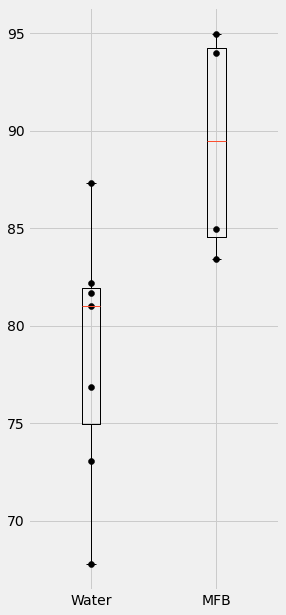

In [12]:
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.best_corrs] for mouse in mice_mfb_disc]
scores_mfb = np.array(scores_mfb).flatten()
scores_water = np.array([mouse.perf()[0] for mouse in mice_water_disc]).flatten()

stdisc, pdisc = ranksums(scores_water, scores_mfb)
print(pdisc)

plt.figure(figsize=(4, 10))
plt.boxplot([scores_water, scores_mfb], vert=True)
plt.xticks([1, 2], labels=['Water', 'MFB'])
plt.scatter([1]*len(scores_water), scores_water, c='black')
plt.scatter([2]*len(scores_mfb), scores_mfb, c='black')
plt.show()


In [18]:
mice_water_pc = load_water(batch3=True, verbose=False, tag='PC', rmgaps='Antonin', linkday=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False, rmgaps='Antonin')

[[7381, 7396]]
[[797, 814]]
[[1376, 1396], [1453, 1481], [1797, 1817], [1876, 1897], [1911, 1936], [2130, 2156], [2578, 2597], [5778, 5816]]
[[4487, 4505], [4583, 4601], [4630, 4659], [4785, 4804], [5133, 5151], [5252, 5288], [5290, 5321], [5323, 5341]]
[[164, 192], [232, 265], [588, 603], [1874, 1895]]
[[871, 888], [893, 911], [931, 949], [8563, 8578]]
[[1146, 1175]]
[[343, 370], [395, 416], [418, 435], [692, 707], [716, 735], [741, 758], [1451, 1491], [1581, 1597], [1614, 1635], [1655, 1690], [1718, 1758], [1780, 1810], [1844, 1861], [2037, 2086], [2105, 2130], [2132, 2205], [2944, 2998], [3011, 3078], [3181, 3196], [5577, 5593], [5612, 5631], [5638, 5700], [6316, 6331]]


240
240
240
240
240
286
320
320
320
320
320
320
320
210
240
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
240
240
320
320
320
320
320
320
320
320
240
240
225
240
305
320
320
320
320
276
295
305
268
278
320
320
320
278
305
320
320
320
240
240
240
158
240
283
320
320
285
320
301
320
412
320
279
320
320
320
259
320
320
320
320
180
198
223
240
223
244
320
285
277
296
320
320
320
320
320
297
320
320
320
320
320
320
224
218
190
305
320
275
259
320
320
320
320
320
320
320
320
296
320
283
320
320
[320, 320, 320, 320, 320, 320, 320]
[1915, 2236, 1877, 2075, 701, 1756, 1593, 1422]
0.0011937454448720057


/home/anverdie/.conda/envs/kaggle/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


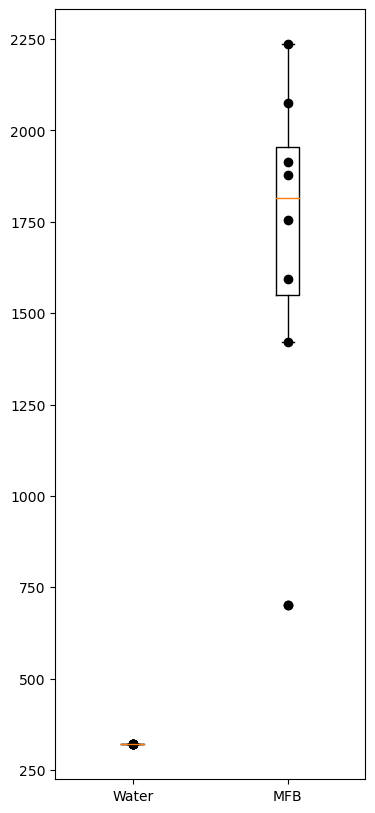

In [13]:
# Get best longest sessions in both methods
scores_water = [mouse.perf()[0] for mouse in mice_water_pc]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_pc]

for m in mice_water_pc:
    for f in m.elphy:
        print(len(f.tr_type))

distrib = []
for i, m in enumerate(scores_water):
    curr_d = []
    for j, sess in enumerate(m):
        if sess > 80:
            curr_d.append(len(mice_water_pc[i].elphy[j].tr_corr))
    distrib.append(np.max(curr_d))

distrib_mfb = []
for i, m in enumerate(scores_mfb):
    curr_d = []
    for j, sess in enumerate(m):
        if sess > 80:
            curr_d.append(len(mice_mfb_pc[i].corrs[j]))
    distrib_mfb.append(np.max(curr_d))
        
print(distrib)
print(distrib_mfb)

stdisc, pdisc = ranksums(distrib, distrib_mfb)
print(pdisc)

np.save('Paper/BoxPlotBestLengthTrial', (distrib, distrib_mfb))

plt.figure(figsize=(4, 10))

plt.boxplot([distrib, distrib_mfb], vert=True)
plt.xticks([1, 2], labels=['Water', 'MFB'])
plt.scatter([1]*len(distrib), distrib, c='black')
plt.scatter([2]*len(distrib_mfb), distrib_mfb, c='black')
plt.savefig('Paper/BoxPlotBestLengthTrial.svg')
plt.show()

# Mettre une observation comme quoi le nombre de trial est gardé à 320 pour 
# maintenir une bonne déprivation hydrique. Avec l'eau on est soumis à une contrainte
# de liquide donc c'est nbormal de ne pas avoir beaucouàp plus de jitter. 
# Metrtre en lien avec poids et perf pour montrer quy'on sait bien faire une depriv

In [15]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps='Antonin', linkday=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False, rmgaps='Antonin')

[[7381, 7396]]
[[797, 814]]
[[1376, 1396], [1453, 1481], [1797, 1817], [1876, 1897], [1911, 1936], [2130, 2156], [2578, 2597], [5778, 5816]]
[[4487, 4505], [4583, 4601], [4630, 4659], [4785, 4804], [5133, 5151], [5252, 5288], [5290, 5321], [5323, 5341]]
[[164, 192], [232, 265], [588, 603], [1874, 1895]]
[[871, 888], [893, 911], [931, 949], [8563, 8578]]
[[1146, 1175]]
[[343, 370], [395, 416], [418, 435], [692, 707], [716, 735], [741, 758], [1451, 1491], [1581, 1597], [1614, 1635], [1655, 1690], [1718, 1758], [1780, 1810], [1844, 1861], [2037, 2086], [2105, 2130], [2132, 2205], [2944, 2998], [3011, 3078], [3181, 3196], [5577, 5593], [5612, 5631], [5638, 5700], [6316, 6331]]


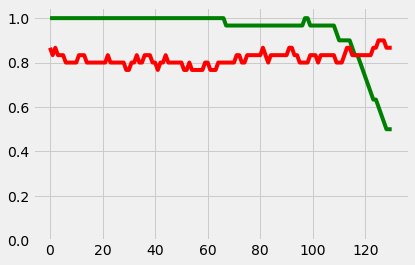

In [16]:
smoothness = 30

unique_mouse = mice_water_pc[6]
perfs_unique, dates = unique_mouse.perf()

trial = 18
s = unique_mouse.elphy[18]
if perfs_unique[trial] > 80:
    last_session = s

    gos = [c for c, t in zip(s.tr_corr, s.ta_type) if t == 1]
    nogos = [c for c, t in zip(s.tr_corr, s.ta_type) if t == 2]

    conv_gos = np.convolve(gos, np.ones(smoothness)/smoothness, mode='valid')
    conv_nogos = np.convolve(nogos, np.ones(smoothness)/smoothness, mode='valid')

    plt.plot(conv_gos, c='green')
    plt.plot(conv_nogos, c='red')
    plt.ylim((0, 1.05))
    plt.show()

In [121]:
smoothness = 30
mouse = mice_mfb_pc[3]
trial = 2

corrs = np.array(mouse.corrs[trial])
idtrials = np.array(mouse.idtrials[trial])

gos = [c for c, t in zip(corrs, idtrials) if t == 1]
nogos = [c for c, t in zip(corrs, idtrials) if t == 2]

conv_gos = np.convolve(gos, np.ones(smoothness)/smoothness, mode='valid')
conv_nogos = np.convolve(nogos, np.ones(smoothness)/smoothness, mode='valid')

np.save('Paper/Example Mouse MFB', (conv_gos, conv_nogos))

plt.plot(conv_gos, c='green', label='go')
plt.plot(conv_nogos, c='red', label='nogo')
plt.ylim((0, 1.05))
plt.legend()
plt.savefig('Paper/Example mouse MFB.svg')
plt.show() 

NameError: name 'mice_mfb_pc' is not defined

In [130]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps='Antonin', linkday=True)

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


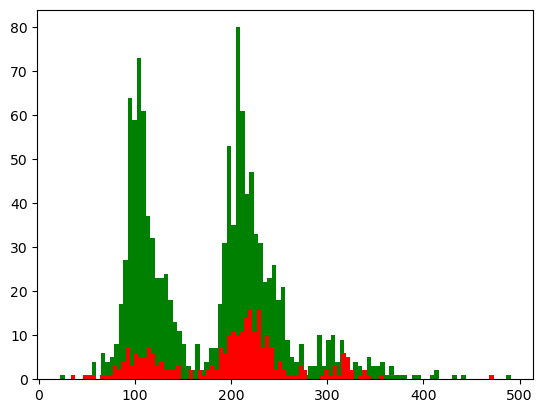

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


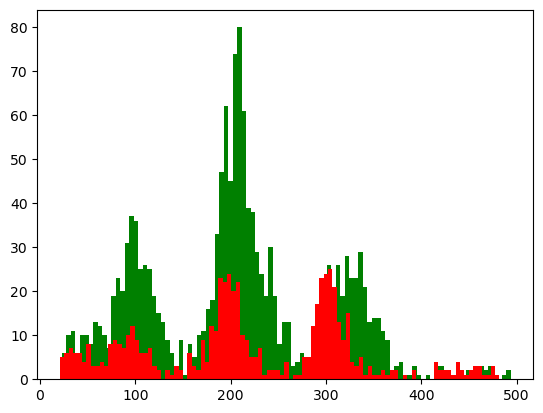

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


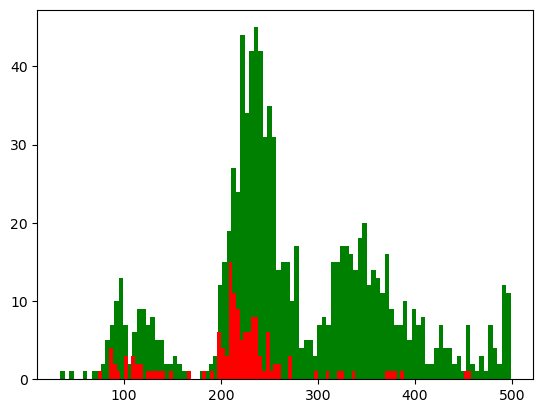

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


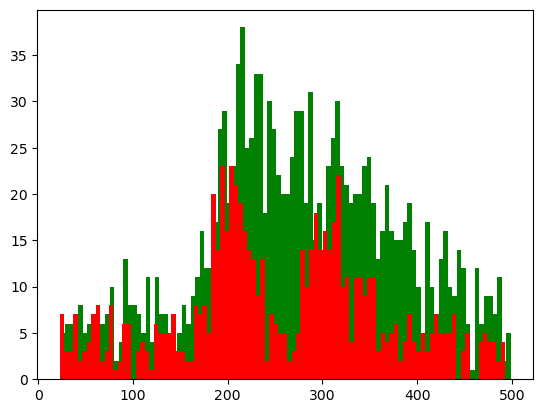

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


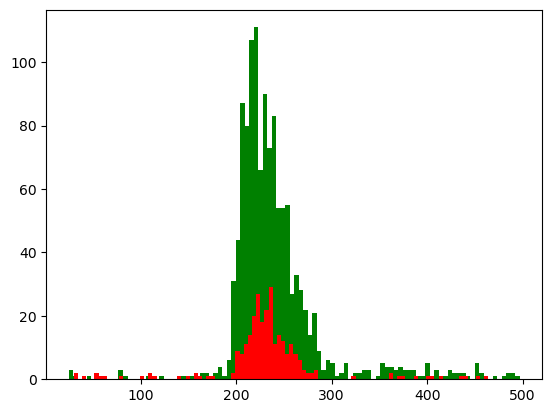

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


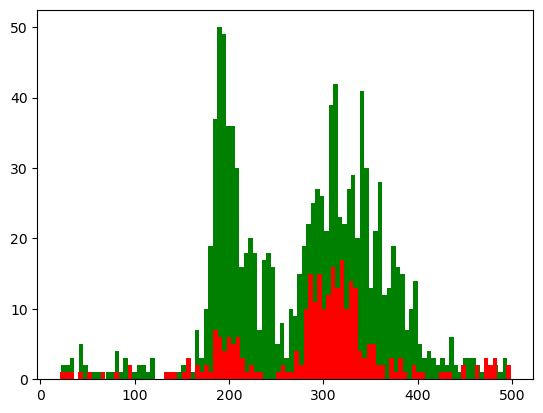

100.0
100.0
100.0
100.0
100.0
100.0
100.0


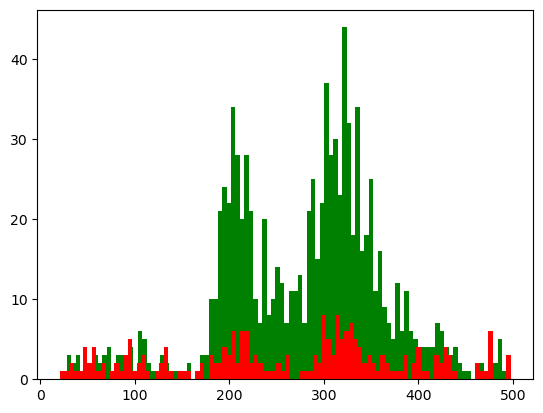

In [131]:
for mouse in mice_water_pc:
    perfs = mouse.perf()[0]
    day_over80_water = np.where(np.array(perfs) >= 80)[0]
    
    all_golicks, all_nogolicks = [], []
    for s in day_over80_water:
        s = mouse.elphy[s]
        print(s.xpar['fix']['StimDelay'])
        gos = [i for i, (c, t) in enumerate(zip(s.tr_corr, s.ta_type)) if ((t == 1) & (c == 1))]
        nogos = [i for i, (c, t) in enumerate(zip(s.tr_corr, s.ta_type)) if ((t == 2) & (c == 1))]
        
        all_golicks.append([s.first_lick[i] for i in gos])
        all_nogolicks.append([s.first_lick[i] for i in nogos])
        
    all_golicks = [l for s in all_golicks for l in s]
    all_nogolicks = [l for s in all_nogolicks for l in s]

    all_golicks, all_nogolicks = np.array(all_golicks), np.array(all_nogolicks)
    
    all_golicks = all_golicks[(all_golicks > 20) & (all_golicks < 500)]  
    all_nogolicks = all_nogolicks[(all_nogolicks > 20) & (all_nogolicks < 500)] 

    plt.hist(all_golicks, bins=100, color='green')
    plt.hist(all_nogolicks, bins=100, color='red')

    plt.show()
    plt.close()

In [22]:
mice_water_pc = load_water(batch3=True, verbose=True, tag='PC', linkday=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False)

Processing files for mice 741150...
PC_3112021_741150_1.DAT
PC_08112021_741150_1.DAT
PC_18112021_741150_1.DAT
PC_15112021_74150_1.DAT
PC_04112021_741150_1.DAT
PC_03122021_741150_1.DAT
PC_29112021_741150_1.DAT
PC_17112021_741150_1.DAT
PC_24112021_741150_1.DAT
PC_02122021_741150_1.DAT
PC_01122021_741150_1.DAT
PC_03112021_741150_1.DAT
PC_05112021_741150_1.DAT
PC_19112021_741150_1.DAT
PC_06122021_741150_1.DAT
PC_10112021_741150_1.DAT
PC_26112021_741150_1.DAT
PC_22112021_741150_1.DAT
PC_25112021_741150_1.DAT
PC_23112021_741150_1.DAT
PC_12112021_74150_1.DAT
PC_09112021_741150_1.DAT
PC_11112021_74150_1.DAT
PC_16112021_741150_1.DAT
Processing files for mice 741151...
PC_26112021_741151_1.DAT
PC_03112021_741151_1.DAT
PC_02122021_741151_1.DAT
PC_30112021_741151_1.DAT
PC_06122021_741151_1.DAT
PC_08112021_741151_1.DAT
PC_09112021_741151_1.DAT
PC_17112021_741151_1.DAT
PC_25112021_741151_1.DAT
PC_18112021_741151_1.DAT
PC_05112021_741151_1.DAT
PC_23112021_741151_1.DAT
PC_01122021_741151_1.DAT
PC_2211

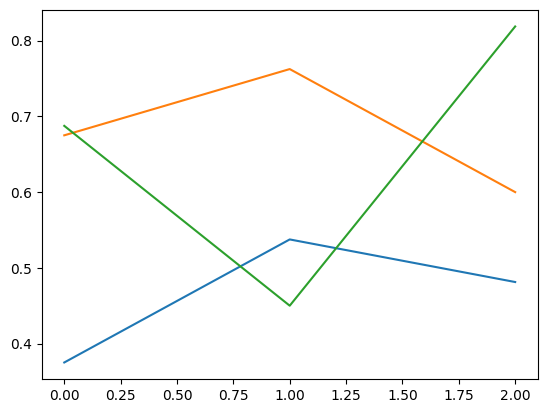

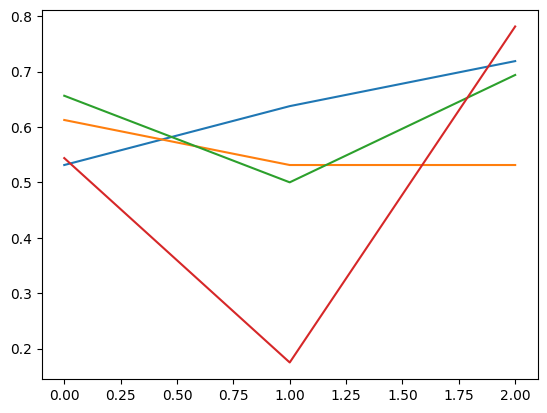

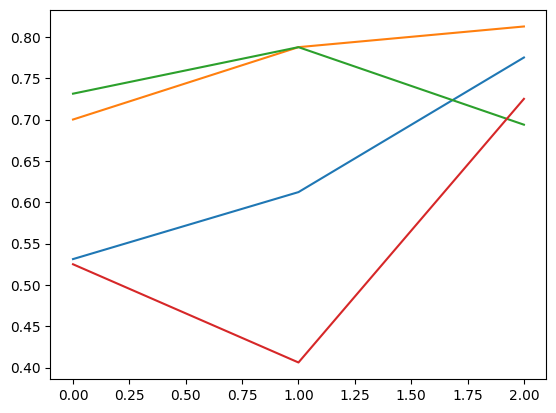

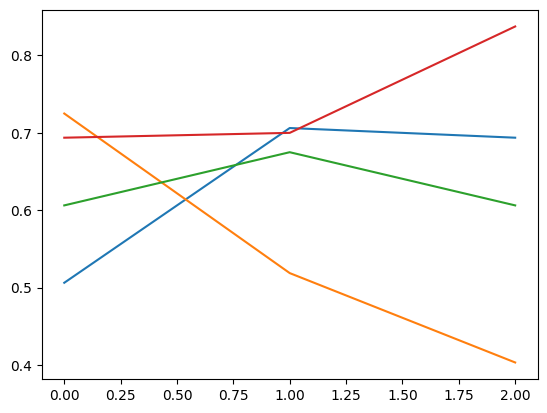

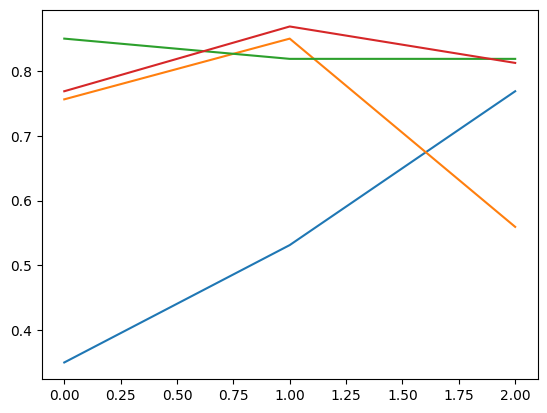

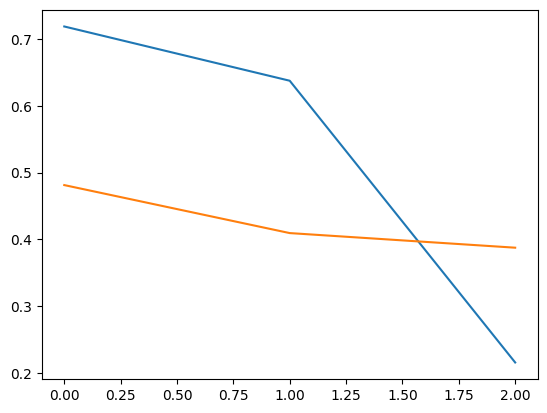

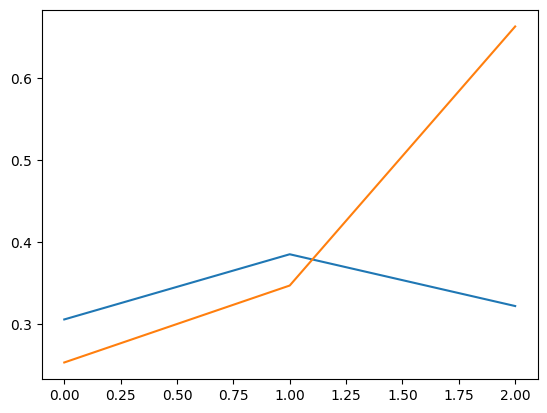

In [28]:
import pandas as pd


## At last, normalize with every monday and increasing 
for mouse in mice_water_pc:
    monday, tuesday, wednesday = [], [], []
    for f in mouse.elphy:
        date = pd.to_datetime(f.date, format='%d%m%Y').date()
        if np.is_busday(date, weekmask='Mon'): monday.append(f)
        elif np.is_busday(date, weekmask='Tue'): tuesday.append(f)
        elif np.is_busday(date, weekmask='Wed'): wednesday.append(f)
    
    monday_acc = []
    for f in monday:
        gos = [c for c, t in zip(f.tr_corr, f.ta_type) if t == 1]
        monday_acc.append(np.sum(gos)/len(gos))
    monday_acc = np.array(monday_acc)
    
    
    tuesday_acc = []
    for f in tuesday:
        gos = [c for c, t in zip(f.tr_corr, f.ta_type) if t == 1]
        tuesday_acc.append(np.sum(gos)/len(gos))
    tuesday_acc = np.array(tuesday_acc)
    
    wednesday_acc = []
    for f in wednesday:
        gos = [c for c, t in zip(f.tr_corr, f.ta_type) if t == 1]
        wednesday_acc.append(np.sum(gos)/len(gos))
    wednesday_acc = np.array(wednesday_acc)
    
    for i in range(len(tuesday_acc)):
        plt.plot([monday_acc[i], tuesday_acc[i], wednesday_acc[i]])
    plt.show()
